## Imports

Needed packages: matplotlib; numpy; pandas; tqdm; stockfish; gym; python-chess; IPython; random; time; chess.engine

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output
import random
!pip install stockfish
from stockfish import Stockfish
Stockfish_path = "C:/Users/Utilizador/Desktop/RL/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2.exe"

import gym
import numpy as np

## MCTS

The folowing code was inspired by the code provided by the Professor.

Node: This class represents a node in the search tree. Each node stores the move that leads to it, its parent node, its children nodes, the number of times it has been visited, the total reward it has accumulated through simulations, and the legal moves that haven't been tried yet from its state.

Used for white player - heuristic_evaluation and evaluate_material_balance: These functions define a heuristic for evaluating the current state of the game, based on the difference in material (i.e., the sum of the piece values) between the two players.

simulate_white and simulate_black: These functions simulate a game until the end from the current state. For simulate_white, the white moves are chosen using the heuristic function and the opposing moves are played by a chess engine (Stockfish). For simulate_black, moves for both players are chosen randomly. This was done to compare a pure MCTS vs a Heuristic MCTS, which also more similar to the other 2 algorithms trained.

monte_carlo_tree_search: This function implements the MCTS algorithm. It first creates the root node with the current state. It then performs a given number of simulations (or "rollouts"), for each of which it descends the tree according to the UCB1 formula (a balance of exploration and exploitation), expands a node (i.e., adds a child node), simulates a game until the end, and then backpropagates the result through the visited nodes. Finally, it chooses the move of the child node with the most visits as the best move.

The code also maintains a statistics_table that records the visits and rewards for each move.

The UCB1 formula in Node.select_child is used to balance exploration (trying out new moves) and exploitation (going with the moves that have yielded high rewards in the past).

In [2]:
import chess
import chess.engine
import chess.svg
from IPython.display import SVG
import math
import random

class Node:
    def __init__(self, move=None, parent=None, state=None):
        self.move = move # The move that leads to this node
        self.parent = parent # Parent node
        self.children = [] # Child nodes
        self.rewards = 0 # Number of rewards after simulations
        self.visits = 0 # Number of times the node has been visited
        self.untried_moves = list(state.legal_moves) if state else []  # Untried moves from this state
        ###
        self.depth = 0 if parent is None else parent.depth + 1  # Depth of this node
        
    '''def select_child(self):
        # Use UCB1 formula () to select the child with the highest UCB value (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjr29GthK__AhXqR6QEHbWKAwgQFnoECBoQAQ&url=https%3A%2F%2Fieor8100.github.io%2Fmab%2FLecture%25203.pdf&usg=AOvVaw0RZpgEMI5JpoHfKc43vycx)
        return max(self.children, key=lambda c: c.rewards / c.visits + math.sqrt(2 * math.log(self.visits) / c.visits))'''

    def select_child(self):
        exploration_factor = math.sqrt(2)  # Exploration factor for UCB1

        # Calculate the UCB1 value for each child node
        ucb_values = [
            (child.rewards / child.visits) + exploration_factor * math.sqrt(
                math.log(self.visits) / child.visits
            )
            for child in self.children
        ]

        # Select the child node with the highest UCB1 value
        max_index = ucb_values.index(max(ucb_values))
        return self.children[max_index]


    def expand(self, state):
        # Take an untried move, create a new state, and add a child node
        move = self.untried_moves.pop()
        new_state = state.copy()
        new_state.push(move)
        child_node = Node(move=move, parent=self, state=new_state)
        self.children.append(child_node)
        return child_node

    def update(self, result):
        # Update the rewards and visits count of the node
        self.visits += 1
        self.rewards += result


def heuristic_evaluation(state):
    # Implement your heuristic evaluation function here
    score = 0

    # Evaluate material balance
    material_balance = evaluate_material_balance(state)
    score += material_balance

    return score


def evaluate_material_balance(state):
    # count the difference in material value between the two players
    white_material = 0
    black_material = 0

    for piece in state.piece_map().values():
        if piece.color == chess.WHITE:
            white_material += piece_value(piece)
        else:
            black_material += piece_value(piece)

    return white_material - black_material


def piece_value(piece):
    # Assign values to each piece type
    if piece.piece_type == chess.PAWN:
        return 1
    elif piece.piece_type == chess.KNIGHT:
        return 3
    elif piece.piece_type == chess.BISHOP:
        return 3
    elif piece.piece_type == chess.ROOK:
        return 3
    elif piece.piece_type == chess.QUEEN:
        return 6
    elif piece.piece_type == chess.KING:
        return 0  # King's value is not considered in material balance


def simulate_white(state, time_limit):
    # Start engine
    engine = chess.engine.SimpleEngine.popen_uci(Stockfish_path)
    engine.configure({"Skill Level": 5})  # Set the engine's skill level to the lowest (weakest) level

    while not state.is_game_over():
        if state.turn:  # If it's white's turn
            # Use heuristic evaluation to estimate the desirability of moves
            moves = list(state.legal_moves)
            move_scores = []
            for move in moves:
                temp_state = state.copy()
                temp_state.push(move)
                score = heuristic_evaluation(temp_state)
                move_scores.append((move, score))

            # Select the move with the highest score
            best_move = max(move_scores, key=lambda x: x[1])[0]
        else:  # If it's engine's turn
            result = engine.play(state, chess.engine.Limit(time=time_limit))  # specify time limit as per your requirement
            best_move = result.move

        # Apply the selected move
        state.push(best_move)
    
    engine.quit()  # stop the engine after game is over

    return get_result_white(state)


def get_result_white(state):
    # Calculate the result of the game (1 for a win, -1 for a loss, 0 for a draw)
    if state.is_checkmate():
        if state.turn:
            return -1 + state.fullmove_number / 10.0  # Adding the number of moves
        else:
            return 20 + state.fullmove_number / 10.0  # Adding the number of moves
    else:
        return 10 + state.fullmove_number / 10.0  # Adding the number of moves

def get_result_black(state):
    # Calculate the result of the game (1 for a win, -1 for a loss, 0 for a draw)
    if state.is_checkmate():
        if state.turn:
            return 20 + state.fullmove_number / 10.0  # Adding the number of moves
        else:
            return -1 + state.fullmove_number / 10.0  # Adding the number of moves
    else:
        return 10 + state.fullmove_number / 10.0  # Adding the number of moves

def simulate_black(state):
    # Simulate a game from the current state until the end
    while not state.is_game_over():
        # Choose a random move from the legal moves
        move = random.choice(list(state.legal_moves))
        state.push(move)
    return get_result_black(state)


def monte_carlo_tree_search(state, simulations, statistics_table, scenario, time_limit):
    root = Node(state=state)

    for _ in range(simulations):
        node = root
        temp_state = state.copy()

        while node.untried_moves == [] and node.children != []:
            node = node.select_child()
            temp_state.push(node.move)

        if node.untried_moves:
            node = node.expand(temp_state)

        if scenario == 'WHITE':
            result = simulate_white(temp_state, time_limit)
        else:
            result = simulate_black(temp_state)

        while node is not None:
            node.update(result)
            node = node.parent

    if root.children:
        best_move = max(root.children, key=lambda c: c.visits).move
    else:
        # No legal moves available, choose a random move
        legal_moves = list(state.legal_moves)
        best_move = random.choice(legal_moves)

    if best_move in statistics_table:
        statistics_table[best_move]['visits'] += 1
        statistics_table[best_move]['rewards'] += result
    else:
        statistics_table[best_move] = {'visits': 1, 'rewards': result}

    return best_move, root

#### Functions used for analyzing and understanding the result and structure

These are utility functions used for analyzing and understanding the result and structure of the Monte Carlo Tree Search (MCTS). 

interpret_result_white and interpret_result_black: These functions take in the result string from a chess game (for instance, as given by the Board.result() method in the python-chess package), and interpret it from the perspective of the white and black players, respectively.

get_tree_depth_and_breadth: This function takes in the root node of an MCTS tree and returns its maximum depth and breadth. The depth of a tree is the length of the longest path from the root to any leaf, and the breadth of a tree is the maximum number of children any node in the tree has.

get_nodes_per_depth: This function takes in the root node of an MCTS tree and returns a dictionary where the keys are depths and the values are the number of nodes at that depth. It's a useful function for understanding the distribution of nodes in the tree across different depths.

get_max_moves_node: This function takes in the root node of an MCTS tree and returns the node that has the maximum number of untried moves. This might be useful for understanding which positions in the game have the most unexplored potential.

In [3]:
def interpret_result_white(result):
    if result == "1-0":
        return "Win"
    elif result == "0-1":
        return "Loss"
    elif result == "1/2-1/2":
        return "Draw"
    else:
        return "Unknown"

def interpret_result_black(result):
    if result == "0-1":
        return "Win"
    elif result == "1-0":
        return "Loss"
    elif result == "1/2-1/2":
        return "Draw"
    else:
        return "Unknown"

def get_tree_depth_and_breadth(root):
    max_depth = root.depth
    max_breadth = len(root.children)
    
    nodes = list(root.children)  # Start with the children of the root
    while nodes:
        current_node = nodes.pop(0)
        max_depth = max(max_depth, current_node.depth)
        max_breadth = max(max_breadth, len(current_node.children))
        nodes.extend(current_node.children)
    
    return max_depth, max_breadth

def get_nodes_per_depth(root):
    nodes_per_depth = {}
    
    nodes = [root]  # Start with the root
    while nodes:
        current_node = nodes.pop(0)
        depth = current_node.depth
        if depth not in nodes_per_depth:
            nodes_per_depth[depth] = 0
        nodes_per_depth[depth] += 1
        nodes.extend(current_node.children)
    
    return nodes_per_depth

def get_max_moves_node(root):
    max_moves_node = root
    nodes = [root]  # Start with the root
    while nodes:
        current_node = nodes.pop(0)
        if len(current_node.untried_moves) > len(max_moves_node.untried_moves):
            max_moves_node = current_node
        nodes.extend(current_node.children)
    return max_moves_node

## Gameplay functions


These are the functions that drive the actual gameplay for the agent playing as either white or black. Here's a description of each one:

play_white and play_black: These functions simulate multiple games of chess against a chess engine (Stockfish), where the agent plays as the white or black side respectively. For each game, they use the Monte Carlo Tree Search (MCTS) algorithm to choose moves when it's the agent's turn. They keep track of various statistics about each game, including the final result, the number of moves made by the agent, and information about the MCTS tree at the end of the game.
Each game is played until it ends naturally (e.g., by checkmate, stalemate, or threefold repetition). The chosen moves of the agent and the engine are applied to a chess.Board object.

The agent's moves are determined by calling the monte_carlo_tree_search function, which runs MCTS for a given number of simulations and returns the move with the most visits in the search tree. On the other hand, the engine's moves are determined by calling the engine.play function with a certain time limit for the engine to make a decision.

After each game, the functions calculate a reward based on the final board state, update the statistics table, and create a dictionary with various details about the game. These details include the raw and interpreted game results, the number of moves made by the agent, and various metrics related to the search tree used by MCTS (like its maximum depth and breadth, the number of nodes at each depth, the node with the most untried moves, and the number of untried moves at that node). These details are then added to a list of results for all games.

At the end of each function, the chess engine is quit, and the list of game results, list of rewards, and updated statistics table are returned.

The statistics table is a dictionary where the keys are moves made by the agent and the values are dictionaries with 'visits' and 'rewards' keys, representing the number of times the move was visited during MCTS and the reward obtained after making that move, respectively.

In [4]:
def play_white(num_games, simulations, statistics_table_white, skill_level, time_limit):
    engine = chess.engine.SimpleEngine.popen_uci(Stockfish_path)
    engine.configure({"Skill Level": skill_level})  # Set the engine's skill level specified level - between 0 and 20
    rewards = []
    results = []

    for game in range(num_games):
        board = chess.Board()
        counter = 0

        while not board.is_game_over():
            if board.turn:
                move, root = monte_carlo_tree_search(board, simulations, statistics_table_white, 'WHITE', time_limit)
                counter += 1
            else:
                eng = engine.play(board, chess.engine.Limit(time=time_limit))  # time limit for the engine to "think"
                move = eng.move
                
            board.push(move)
        
        reward = get_result_white(board)
        rewards.append(reward)

        result = {
            "game_result": board.result(),
            "interpreted_result": interpret_result_white(board.result()),
            "move_counter": counter,
            "max_tree_depth": get_tree_depth_and_breadth(root)[0],
            "max_tree_breadth": get_tree_depth_and_breadth(root)[1],
            "nodes_per_depth": get_nodes_per_depth(root),
            "max_moves_node": get_max_moves_node(root),
            "num_untried_moves": len(get_max_moves_node(root).untried_moves)
        }

        results.append(result)
        if (game + 1) % (num_games // 10) == 0:
            progress = (game + 1) * 100 // num_games
            print("White Progress:", progress, "%")
    engine.quit()

    return results, rewards, statistics_table_white

def play_black(num_games, simulations, statistics_table_black, skill_level, time_limit):
    engine = chess.engine.SimpleEngine.popen_uci(Stockfish_path)
    engine.configure({"Skill Level": skill_level})  # Set the engine's skill level specified level - between 0 and 20
    statistics_table = {}  # Global statistics table
    rewards = []
    results = []

    for game in range(num_games):
        board = chess.Board()
        counter = 0

        while not board.is_game_over():
            if board.turn:
                eng = engine.play(board, chess.engine.Limit(time= time_limit))
                move = eng.move            
            else:
                move, root = monte_carlo_tree_search(board, simulations, statistics_table_black, 'BLACK', time_limit)
                counter += 1
            board.push(move)

        reward = get_result_black(board)
        rewards.append(reward)

        result = {
            "game_result": board.result(),
            "interpreted_result": interpret_result_black(board.result()),
            "move_counter": counter,
            "max_tree_depth": get_tree_depth_and_breadth(root)[0],
            "max_tree_breadth": get_tree_depth_and_breadth(root)[1],
            "nodes_per_depth": get_nodes_per_depth(root),
            "max_moves_node": get_max_moves_node(root),
            "num_untried_moves": len(get_max_moves_node(root).untried_moves)
        }

        results.append(result)
        if (game + 1) % (num_games // 10) == 0:
            progress = (game + 1) * 100 // num_games
            print("Black Progress:", progress, "%")

    engine.quit()

    return results, rewards, statistics_table_black

### Plot Functions


This function, plot_results, takes a list of game results and corresponding rewards and produces a series of plots. The plots show the raw metrics from each game (reward, move counter, max tree depth, max tree breadth, number of untried moves), and the moving average of these metrics over a specified window size (default is 50 games).

The function also calculates and prints the total number of wins, losses, and draws from the played games.

A moving average is a common way to smooth out data over time and identify trends. In this case, it can help us see if the agent is improving over time (if the moving average of rewards is increasing, for example).

The function also plots the distribution of nodes per depth for each game using both a bar chart and a line graph. This can help us understand the shape and size of the search tree generated by the MCTS algorithm.

This is a useful function for visualizing the agent's performance over time and understanding how different metrics evolve during training.

Here's a bit more detail on the steps of the function:

calculate_moving_average: This helper function calculates the moving average of a given data list over a specified window size. It uses the numpy's convolve function to calculate the moving average.

The function then extracts individual lists of game results, interpreted results, move counters, max tree depths, max tree breadths, nodes per depth, and the number of untried moves from the results input list.

It counts the number of wins, losses, and draws and prints these counts.

It plots the raw rewards and the moving average of rewards over time, creating two plots for each. It also does the same for the move counter, max tree depth, max tree breadth, and the number of untried moves.

It creates a bar chart to show the distribution of nodes per depth for each game.

Finally, it creates a line graph to show the distribution of nodes per depth for each game.

The extracted data are used to generate various plots to visualize the performance of the MCTS agent over multiple games. The matplotlib.pyplot library is used for creating these plots.

To summarize, the plot_results function provides a comprehensive visual analysis of the performance of the MCTS agent in chess games against the Stockfish engine. It helps to understand if the agent is learning and improving over time by showing the trend of various performance metrics.






In [5]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_moving_average(data, window_size):
    # Calculate the moving average using a specified window size
    weights = np.repeat(1.0, window_size) / window_size
    moving_average = np.convolve(data, weights, mode='valid')
    return moving_average

def plot_results(results, rewards, window_size=50):
    game_results = [result['game_result'] for result in results]
    interpreted_results = [result['interpreted_result'] for result in results]
    move_counters = [result['move_counter'] for result in results]
    max_tree_depths = [result['max_tree_depth'] for result in results]
    max_tree_breadths = [result['max_tree_breadth'] for result in results]
    nodes_per_depths = [result['nodes_per_depth'] for result in results]
    num_untried_moves = [result['num_untried_moves'] for result in results]
    
    # Plot game results
    outcome_counts = {
        'Win': interpreted_results.count('Win'),
        'Loss': interpreted_results.count('Loss'),
        'Draw': interpreted_results.count('Draw')
    }

    print('Number of Games Won:', outcome_counts['Win'])
    print('Number of Games Lost:', outcome_counts['Loss'])
    print('Number of Games Drawn:', outcome_counts['Draw'])

    # Plotting data and moving averages side by side for each metric

    # Rewards
    fig, axs = plt.subplots(1, 2, figsize=(26, 7))
    axs[0].plot(range(len(rewards)), rewards, '-o')
    axs[0].set_xlabel('Game', fontsize=20)
    axs[0].set_ylabel('Reward', fontsize=20)
    axs[0].set_title('Rewards', fontsize=20)
    rewards_ma = calculate_moving_average(rewards, window_size)
    axs[1].plot(range(window_size - 1, len(rewards)), rewards_ma, '-r', label=f'Moving Average ({window_size}-episode)')
    axs[1].set_xlabel('Game', fontsize=20)
    axs[1].set_ylabel('Reward', fontsize=20)
    axs[1].set_title('Rewards with Moving Average', fontsize=20)
    axs[1].legend(fontsize=20)
    plt.show()

    # Move counters
    fig, axs = plt.subplots(1, 2, figsize=(26, 7))
    axs[0].plot(move_counters, marker='o')
    axs[0].set_xlabel('Game', fontsize=20)
    axs[0].set_ylabel('Move Counter', fontsize=20)
    axs[0].set_title('Move Counter', fontsize=20)
    move_counters_ma = calculate_moving_average(move_counters, window_size)
    axs[1].plot(range(window_size - 1, len(move_counters)), move_counters_ma, '-r', label=f'Moving Average ({window_size}-episode)')
    axs[1].set_xlabel('Game', fontsize=20)
    axs[1].set_ylabel('Move Counter', fontsize=20)
    axs[1].set_title('Move Counter with Moving Average', fontsize=20)
    axs[1].legend(fontsize=20)
    plt.show()

    # Max tree depths
    fig, axs = plt.subplots(1, 2, figsize=(26, 7))
    axs[0].plot(max_tree_depths, marker='o')
    axs[0].set_xlabel('Game', fontsize=20)
    axs[0].set_ylabel('Max Tree Depth', fontsize=20)
    axs[0].set_title('Max Tree Depth', fontsize=20)
    max_tree_depths_ma = calculate_moving_average(max_tree_depths, window_size)
    axs[1].plot(range(window_size - 1, len(max_tree_depths)), max_tree_depths_ma, '-r', label=f'Moving Average ({window_size}-episode)')
    axs[1].set_xlabel('Game', fontsize=20)
    axs[1].set_ylabel('Max Tree Depth', fontsize=20)
    axs[1].set_title('Max Tree Depth with Moving Average', fontsize=20)
    axs[1].legend(fontsize=20)
    plt.show()

    # Max tree breadths
    fig, axs = plt.subplots(1, 2, figsize=(26, 7))
    axs[0].plot(max_tree_breadths, marker='o')
    axs[0].set_xlabel('Game', fontsize=20)
    axs[0].set_ylabel('Max Tree Breadth', fontsize=20)
    axs[0].set_title('Max Tree Breadth', fontsize=20)
    max_tree_breadths_ma = calculate_moving_average(max_tree_breadths, window_size)
    axs[1].plot(range(window_size - 1, len(max_tree_breadths)), max_tree_breadths_ma, '-r', label=f'Moving Average ({window_size}-episode)')
    axs[1].set_xlabel('Game', fontsize=20)
    axs[1].set_ylabel('Max Tree Breadth', fontsize=20)
    axs[1].set_title('Max Tree Breadth with Moving Average', fontsize=20)
    axs[1].legend(fontsize=20)
    plt.show()

    # Number of untried moves
    fig, axs = plt.subplots(1, 2, figsize=(26, 7))
    axs[0].plot(num_untried_moves, marker='o')
    axs[0].set_xlabel('Game', fontsize=20)
    axs[0].set_ylabel('Number of Untried Moves', fontsize=20)
    axs[0].set_title('Number of Untried Moves', fontsize=20)
    num_untried_moves_ma = calculate_moving_average(num_untried_moves, window_size)
    axs[1].plot(range(window_size - 1, len(num_untried_moves)), num_untried_moves_ma, '-r', label=f'Moving Average ({window_size}-episode)')
    axs[1].set_xlabel('Game', fontsize=20)
    axs[1].set_ylabel('Number of Untried Moves', fontsize=20)
    axs[1].set_title('Number of Untried Moves with Moving Average', fontsize=20)
    axs[1].legend(fontsize=20)
    plt.show()


    # Plot nodes per depth
    depths = set()
    for nodes_per_depth in nodes_per_depths:
        depths.update(nodes_per_depth.keys())

    num_games = len(results)
    num_depths = len(depths)
    bar_width = 0.8 / num_games
    x_ticks = np.arange(num_depths)

    plt.figure(figsize=(26, 7))
    for i, nodes_per_depth in enumerate(nodes_per_depths):
        counts = [nodes_per_depth.get(depth, 0) for depth in depths]
        x = x_ticks + (i * bar_width) - (0.4 - (num_games % 2) * 0.5) * bar_width
        plt.bar(x, counts, width=bar_width, label=f'Game {i+1}')

    plt.xlabel('Depth', fontsize=20)
    plt.ylabel('Node Count', fontsize=20)
    plt.title('Nodes per Depth', fontsize=20)
    plt.xticks(x_ticks, depths, fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

    # Plot nodes per depth
    depths = set()
    for nodes_per_depth in nodes_per_depths:
        depths.update(nodes_per_depth.keys())

    num_games = len(results)
    num_depths = len(depths)
    x_ticks = np.arange(num_depths)

    plt.figure(figsize=(26, 7))
    for i, nodes_per_depth in enumerate(nodes_per_depths):
        counts = [nodes_per_depth.get(depth, 0) for depth in depths]
        x = x_ticks
        plt.plot(x, counts, marker='o', label=f'Game {i+1}')

    plt.xlabel('Depth', fontsize=20)
    plt.ylabel('Node Count', fontsize=20)
    plt.title('Nodes per Depth', fontsize=20)
    plt.xticks(x_ticks, depths, fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()




The AGENT_EVALUATION function serves as a testing suite for evaluating the performance of the MCTS agent. It plays a number of games with the agent as both white and black, collects results, rewards, and other statistics, and then calls the plot_results function to visualize these metrics.

**The function accepts five parameters: n_evaluations, sims, avg_window, skill_level_, and time_limit_. These parameters represent the number of games to be played for evaluation, the number of simulations for each move in MCTS, the window size for moving average calculation, the skill level of the Stockfish engine - from 0 to 20, and the time limit for the Stockfish engine to decide on a move, respectively.**

It initiates an empty dictionary statistics_table_white and calls the play_white function to simulate n_evaluations number of games with the agent playing as white. It collects the game results, rewards, and updated statistics in results_white, rewards_white, and statistics_table_white, respectively.

It prints the text "WHITE" in blue, and calls plot_results to visualize the game results and rewards for the agent when it played as white.

The same steps are repeated for the agent playing as black. An empty dictionary statistics_table_black is initiated, and the play_black function is called to simulate n_evaluations number of games with the agent playing as black. It collects the game results, rewards, and updated statistics in results_black, rewards_black, and statistics_table_black, respectively.

It prints the text "BLACK" in blue, and calls plot_results to visualize the game results and rewards for the agent when it played as black.

Finally, it returns all the collected data: results, rewards, and statistics for the agent playing as both white and black.

The function AGENT_EVALUATION is then called with a specific set of parameters: n_evaluations=250, sims=35, avg_window=2, skill_level_=5, and time_limit_=0.001. These parameters specify that the function will simulate 250 games with 35 simulations per move, calculate moving averages over a window of 2 games, play against a Stockfish engine with a skill level of 5, and limit the engine's decision time to 0.001 seconds. The function will return results, rewards, and statistics for the agent playing as both white and black.

In [6]:
def AGENT_EVALUATION(n_evaluations=100, sims=50, avg_window=5, skill_level_=5, time_limit_=0.01):
    statistics_table_white = {}
    results_white, rewards_white, statistics_table_white = play_white(
        num_games=n_evaluations, simulations=sims, statistics_table_white=statistics_table_white, skill_level=skill_level_, time_limit=time_limit_)
    FONT = '\033[1;34m'
    print(FONT + 'WHITE')
    plot_results(results_white, rewards_white, avg_window)
    
    statistics_table_black = {}
    results_black, rewards_black, statistics_table_black = play_black(
        num_games=n_evaluations, simulations=sims, statistics_table_black=statistics_table_black, skill_level=skill_level_, time_limit=time_limit_)
    print(FONT + 'BLACK')
    plot_results(results_black, rewards_black, avg_window)

    return results_white, rewards_white, statistics_table_white, results_black, rewards_black, statistics_table_black

White Progress: 10 %
White Progress: 20 %
White Progress: 30 %
White Progress: 40 %
White Progress: 50 %
White Progress: 60 %
White Progress: 70 %
White Progress: 80 %
White Progress: 90 %
White Progress: 100 %
WHITE
Number of Games Won: 0
Number of Games Lost: 250
Number of Games Drawn: 0


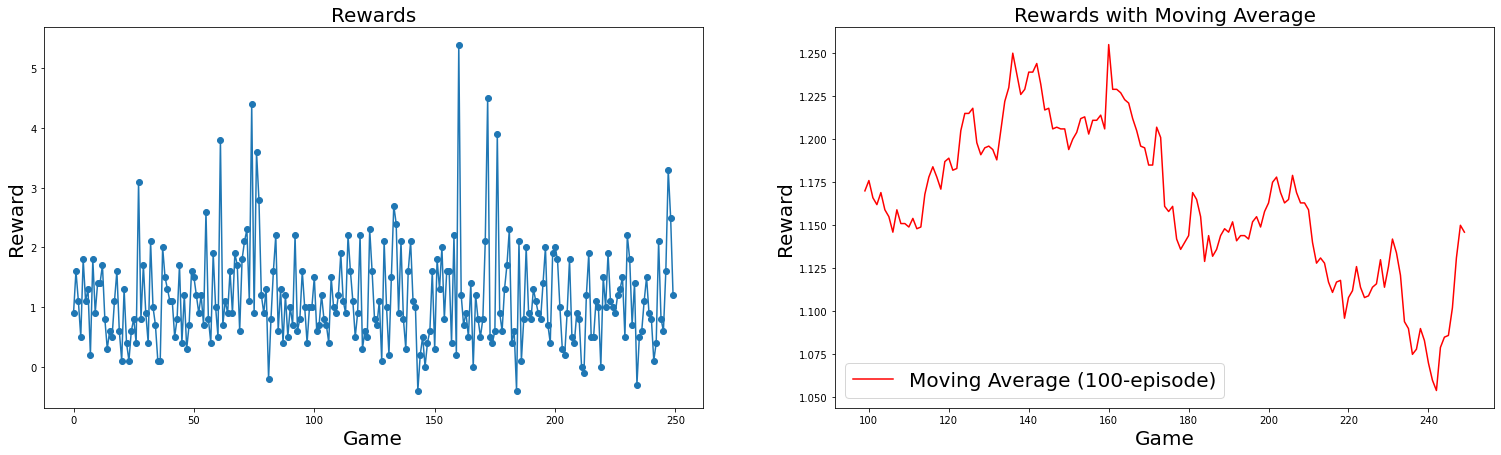

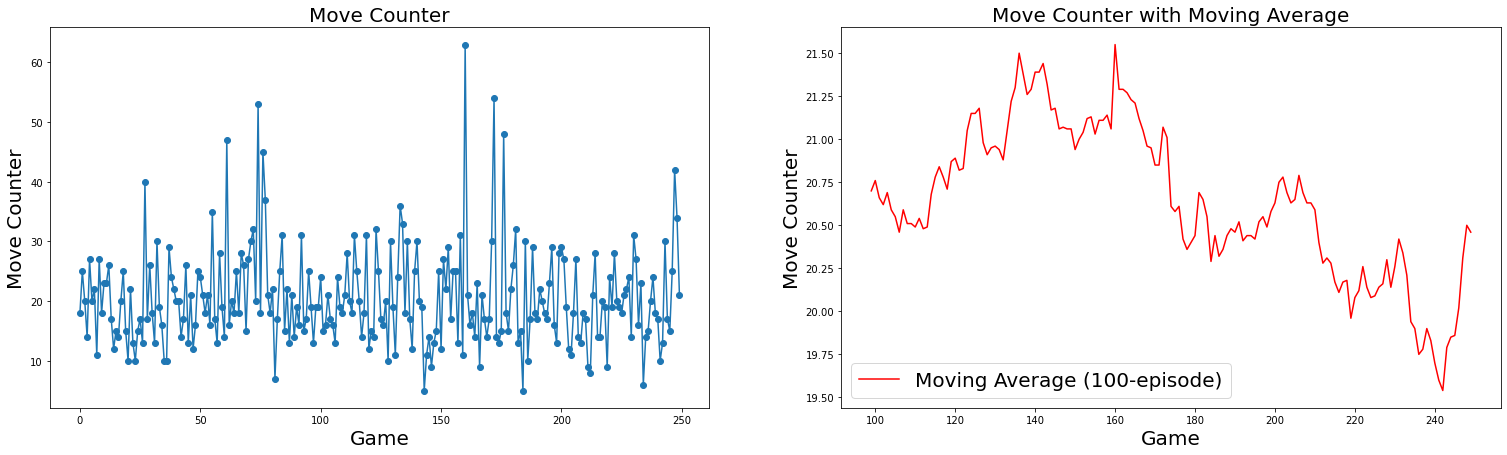

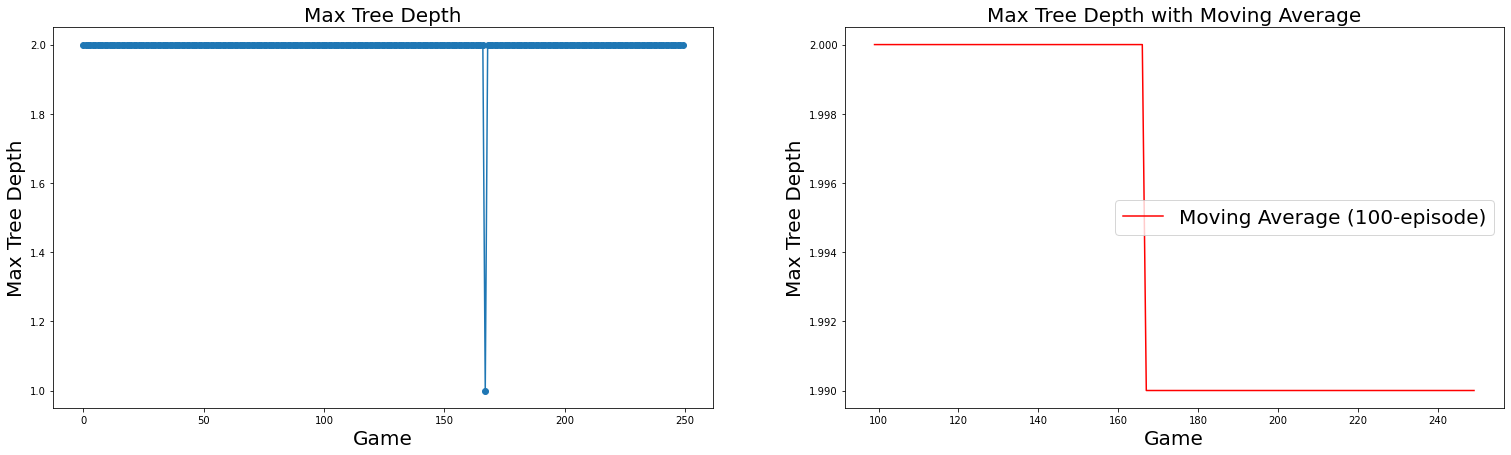

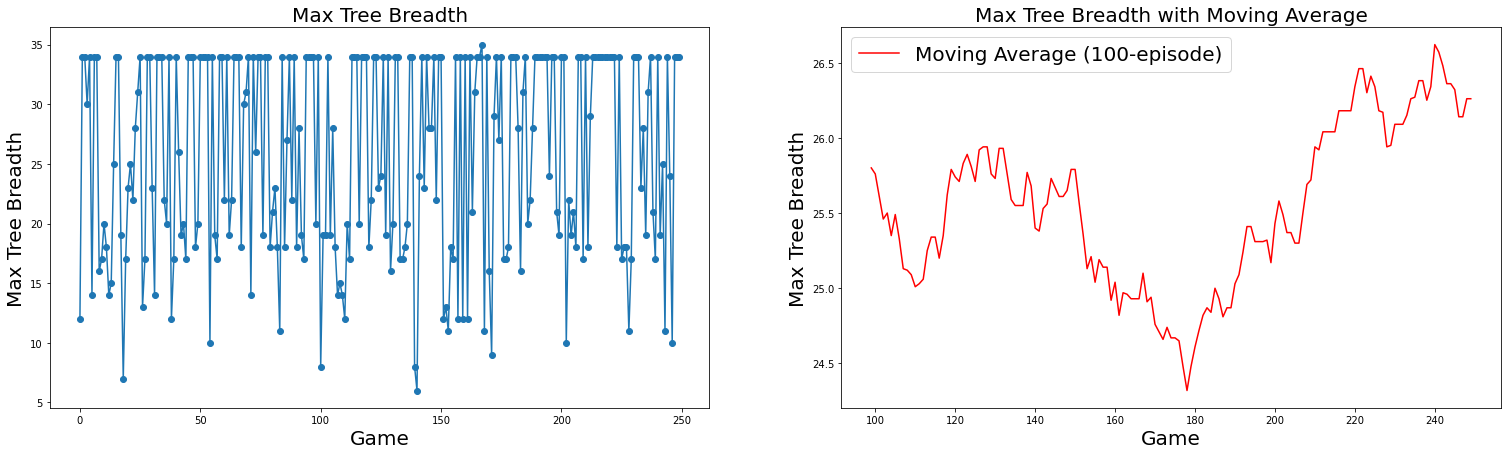

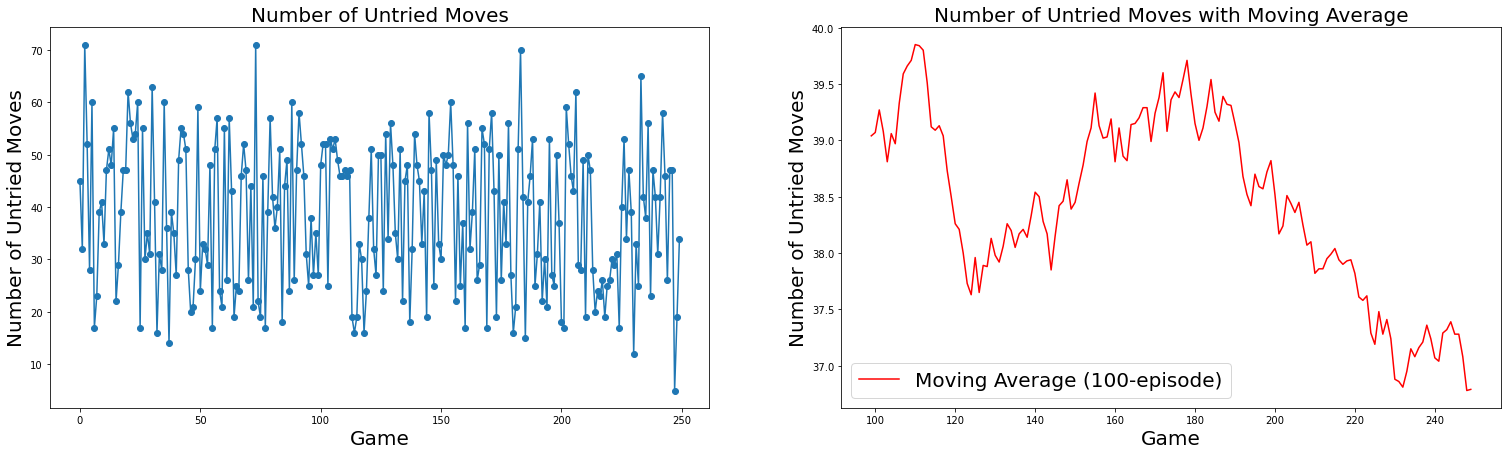

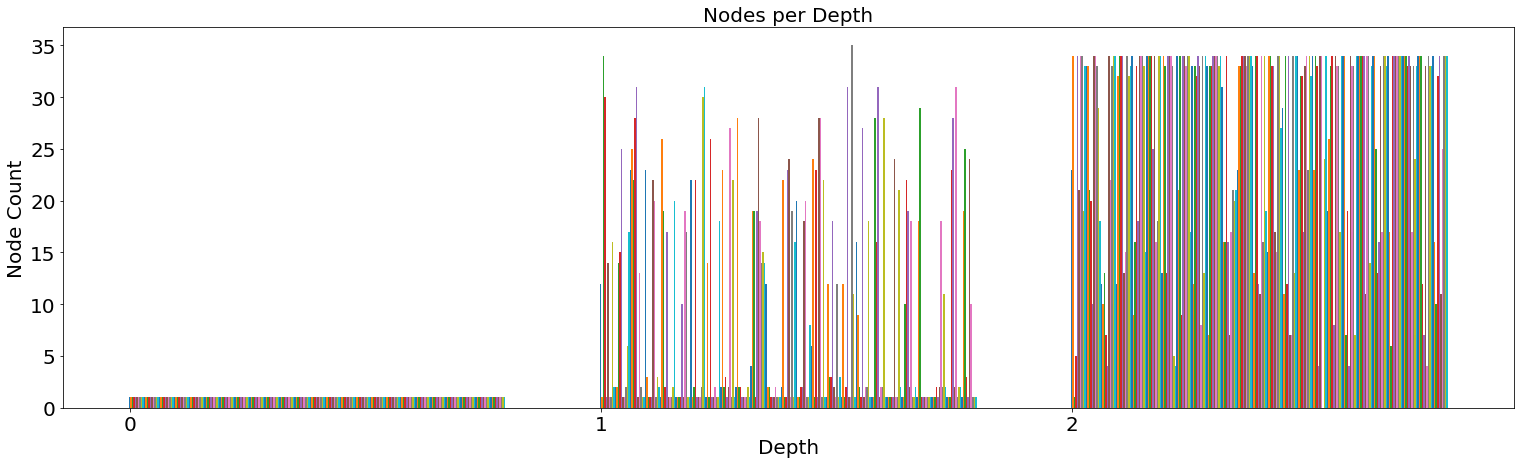

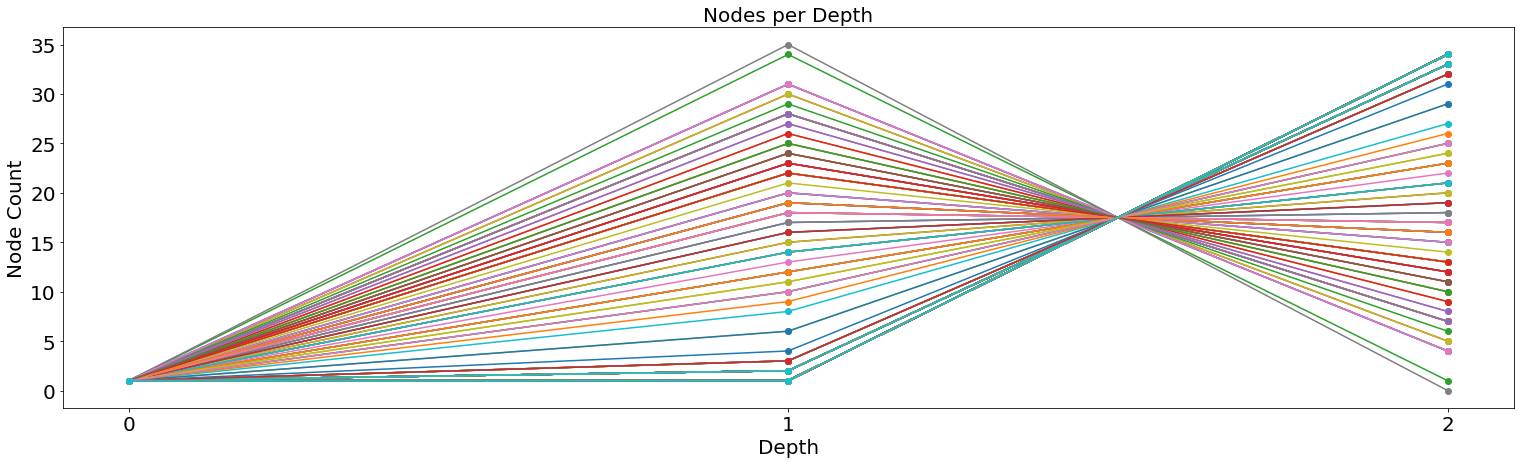

Black Progress: 10 %
Black Progress: 20 %
Black Progress: 30 %
Black Progress: 40 %
Black Progress: 50 %
Black Progress: 60 %
Black Progress: 70 %
Black Progress: 80 %
Black Progress: 90 %
Black Progress: 100 %
BLACK
Number of Games Won: 0
Number of Games Lost: 250
Number of Games Drawn: 0


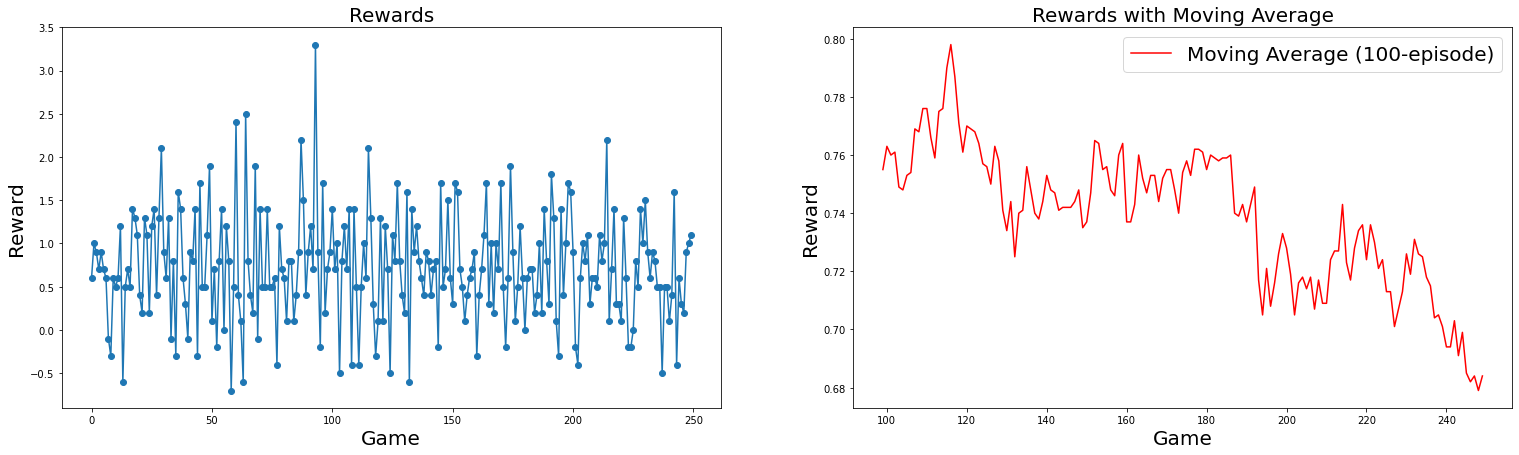

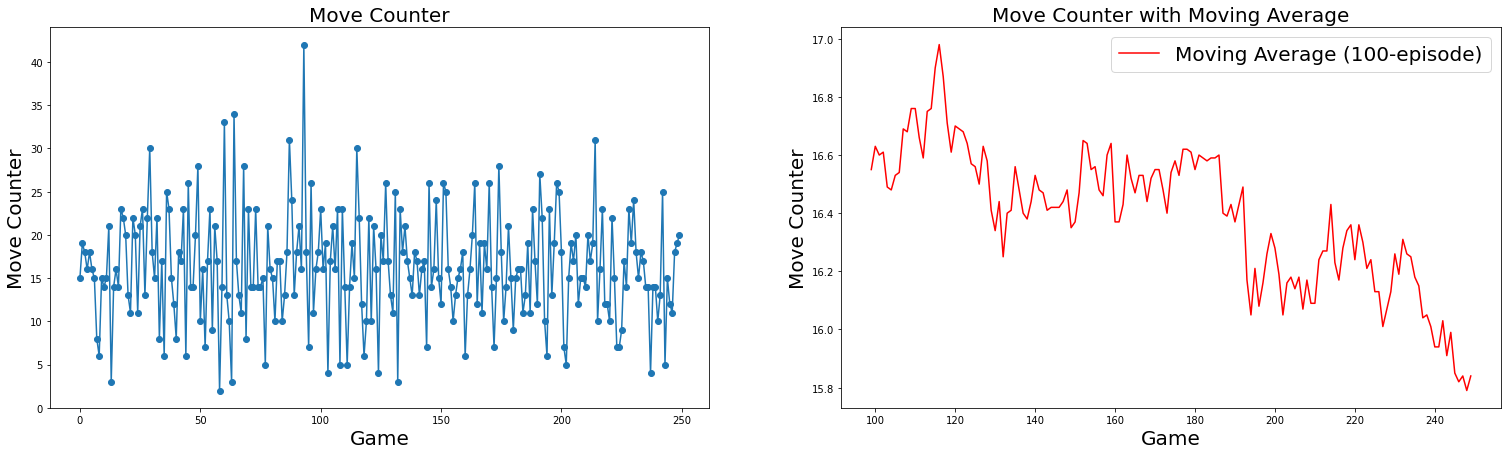

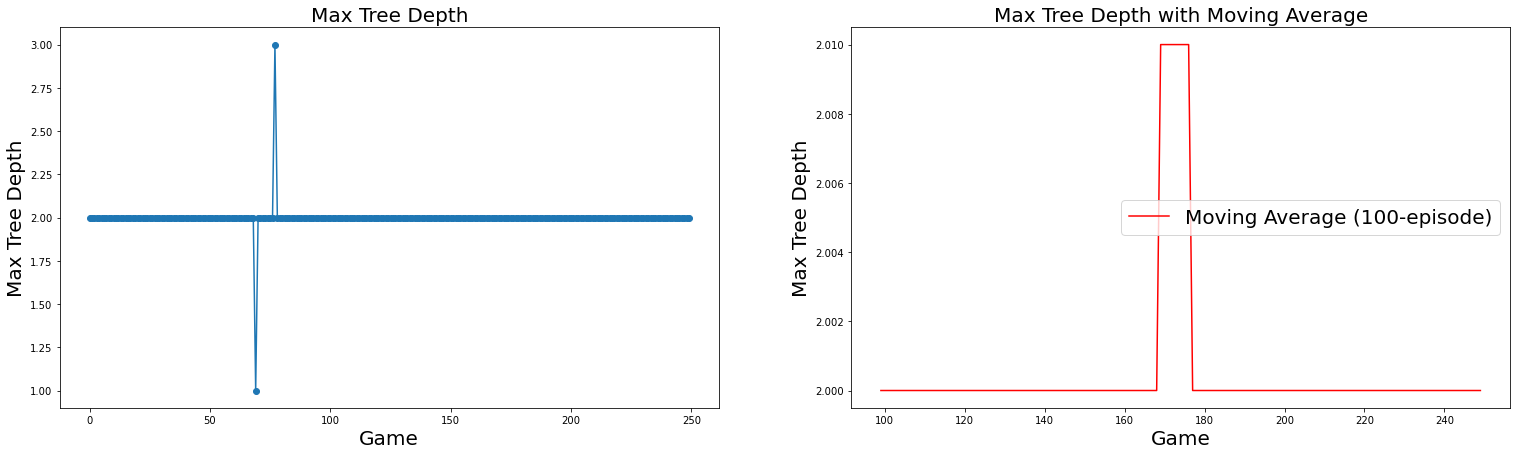

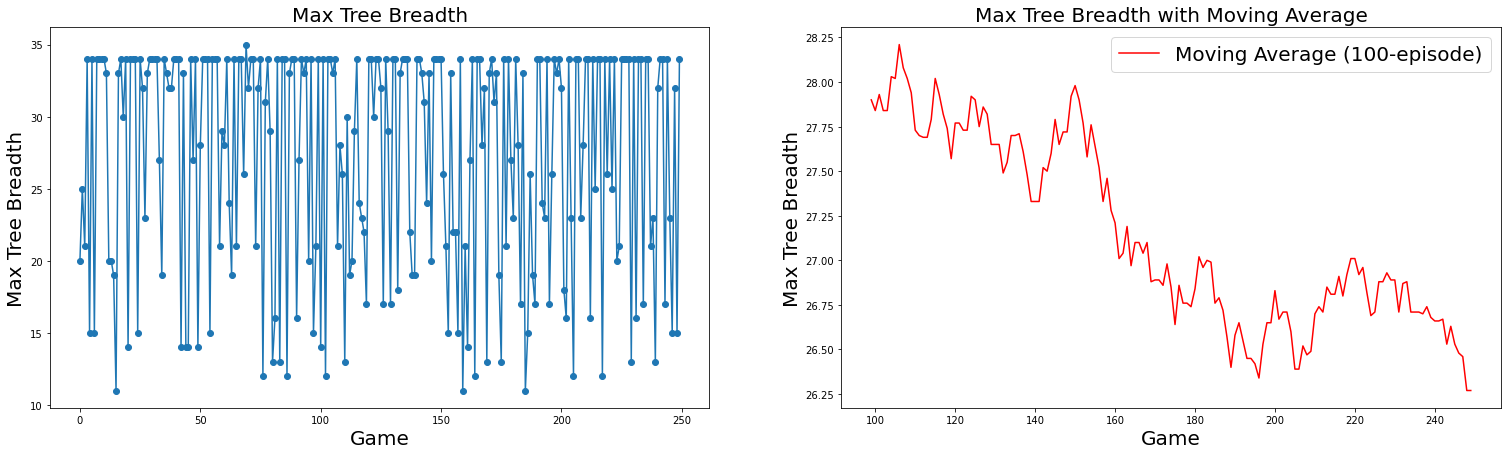

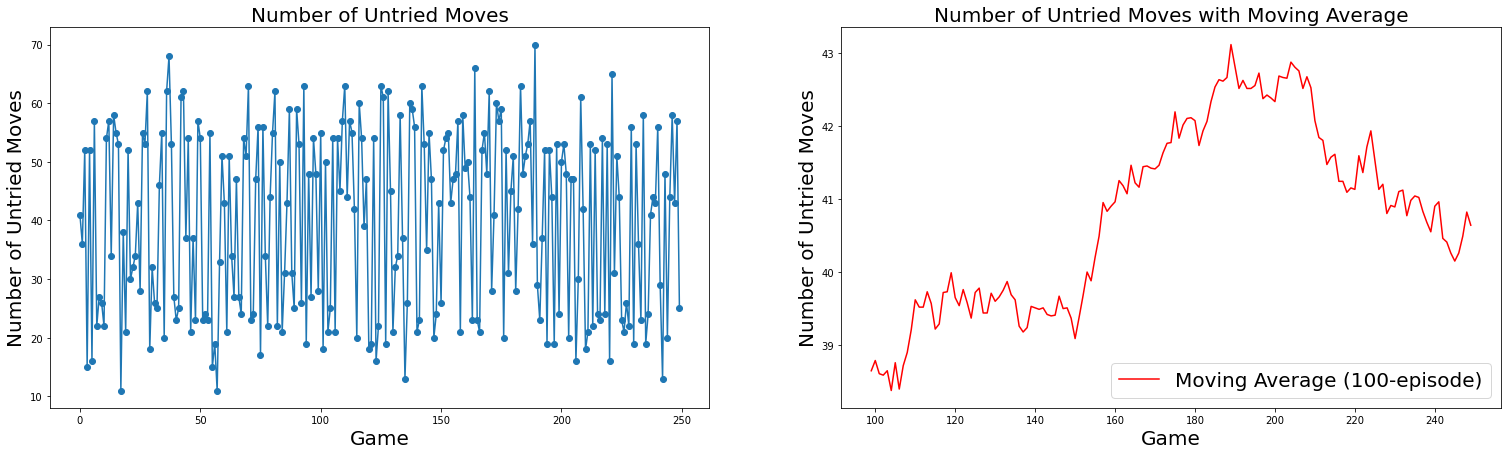

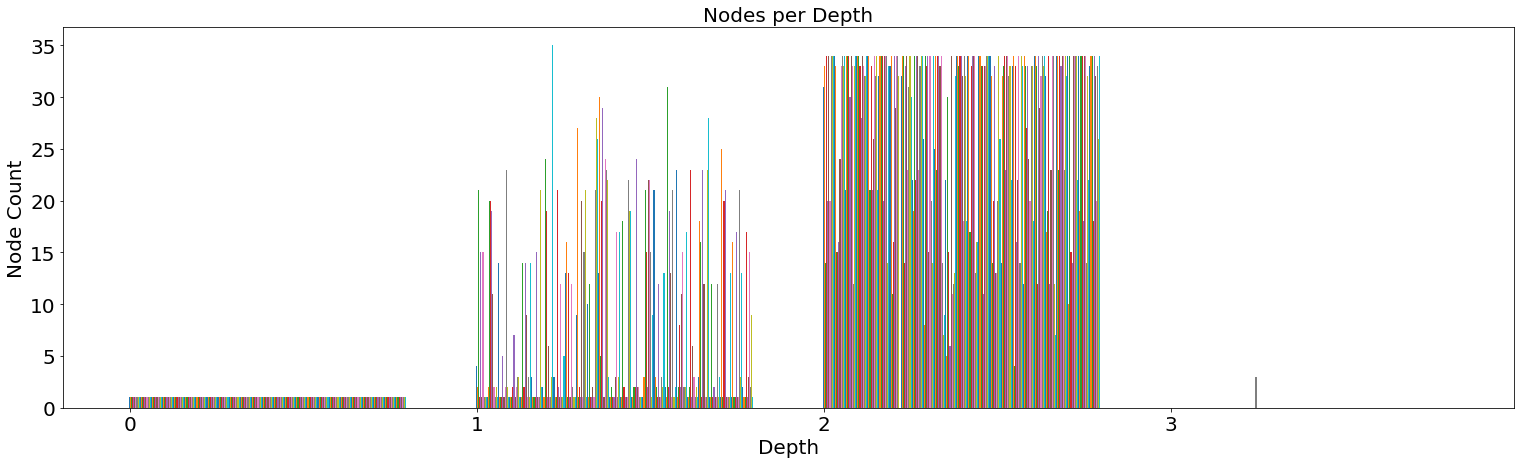

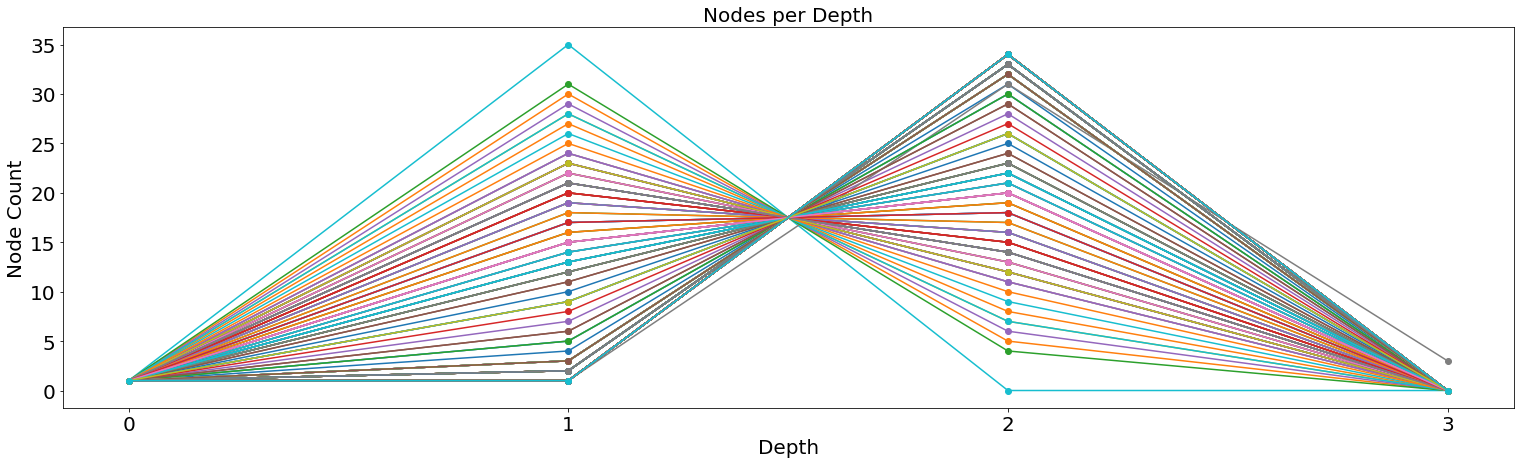

In [7]:
results_white, rewards_white, statistics_table_white, results_black, rewards_black, statistics_table_black = AGENT_EVALUATION(
    n_evaluations=250, sims=35, avg_window=100, skill_level_=5, time_limit_=0.001)

### Visualize next moves after a set board state

This section constists of, after having trained the agent, setting up the board in a specific state, and then see the game play out and each move is marked with an arrow.
The first board state is 1 move away from black mating and the second is one move away from white mating, the one that is about to mate is the first to play.

#### Board setup for Black's imminent victory

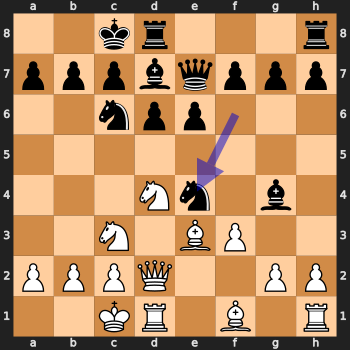

Move: f6e4


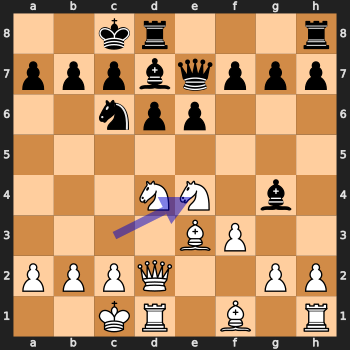

Move: c3e4


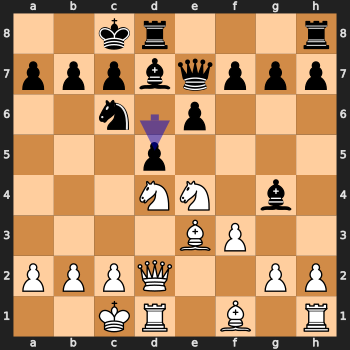

Move: d6d5


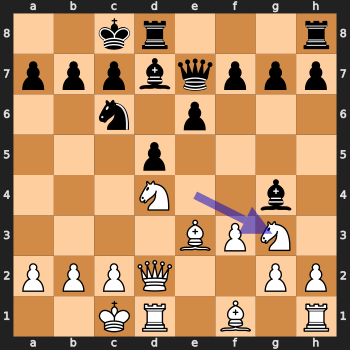

Move: e4g3


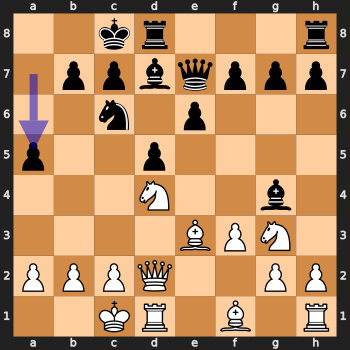

Move: a7a5


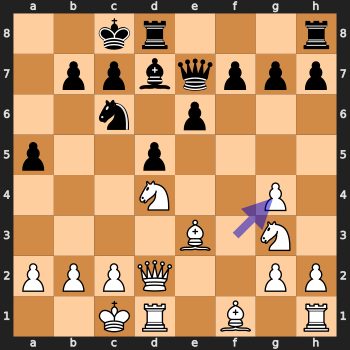

Move: f3g4


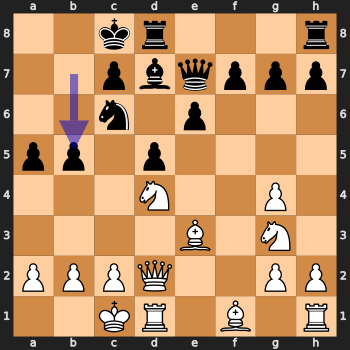

Move: b7b5


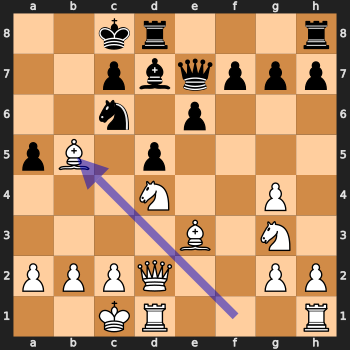

Move: f1b5


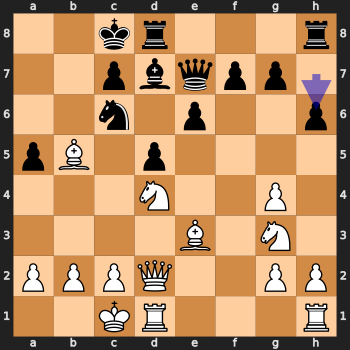

Move: h7h6


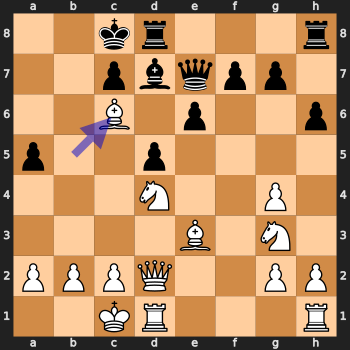

Move: b5c6


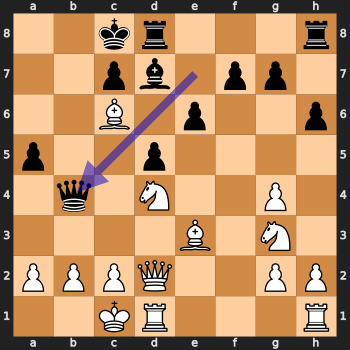

Move: e7b4


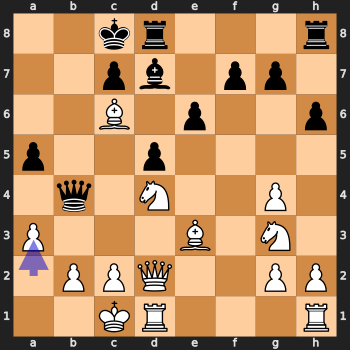

Move: a2a3


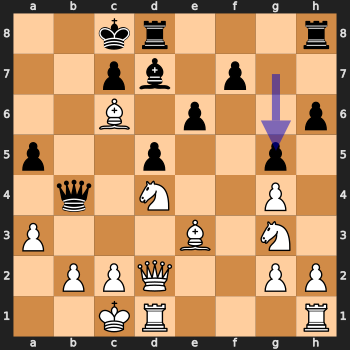

Move: g7g5


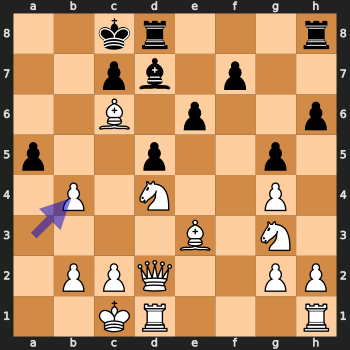

Move: a3b4


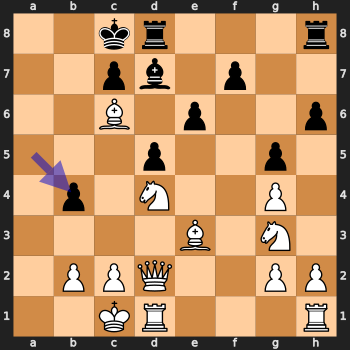

Move: a5b4


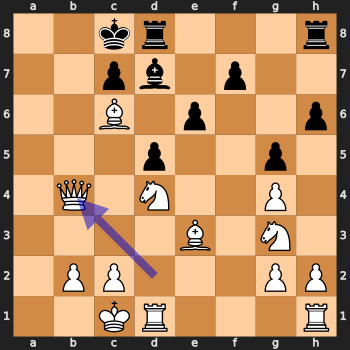

Move: d2b4


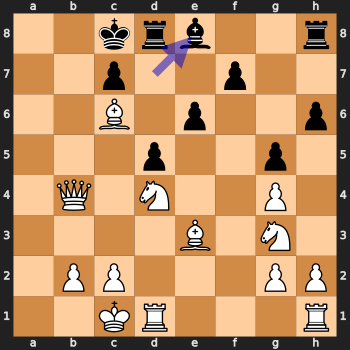

Move: d7e8


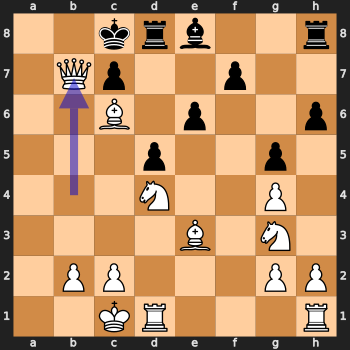

Move: b4b7
0.0
Loss


In [10]:
# Board setup for Black's imminent victory
fen = "2kr3r/pppbqppp/2nppn2/8/3NP1b1/2N1BP2/PPPQ2PP/2KR1B1R b - - 0 1"

statistics_table = statistics_table_black
board = chess.Board(fen)
engine = chess.engine.SimpleEngine.popen_uci(Stockfish_path)
simulations = 35

while not board.is_game_over():
    if not board.turn:  # if it's black's turn
        move, root = monte_carlo_tree_search(board, simulations, statistics_table, 'BLACK', time_limit)
    else:
        result = engine.play(board, chess.engine.Limit(time=0.01))
        move = result.move

    board.push(move)
    a = chess.svg.board(
        board,
        arrows=[chess.svg.Arrow(move.from_square, move.to_square, color="#0000cccc")],
        size=350,
    )
    display(SVG(a))
    print("Move:", move)

print(get_result_black(board))
print(interpret_result_black(board.result()))
engine.quit()

#### Board setup for White's imminent victory

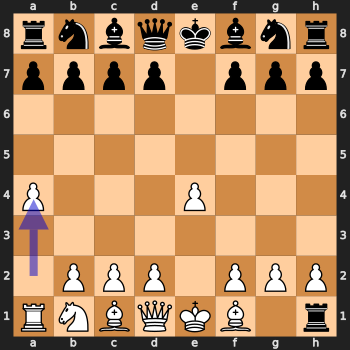

Move: a2a4


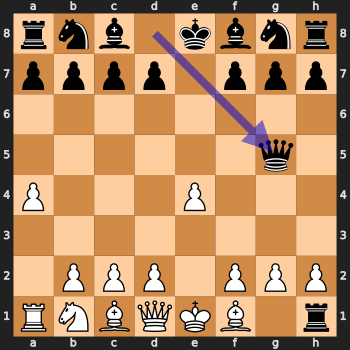

Move: d8g5


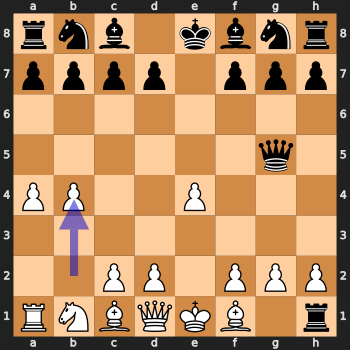

Move: b2b4


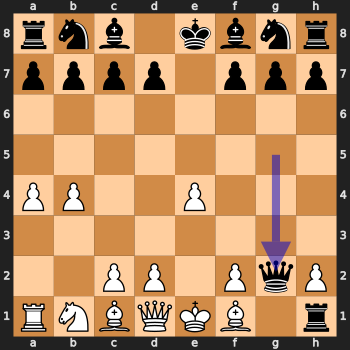

Move: g5g2


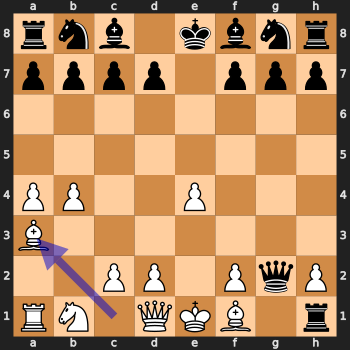

Move: c1a3


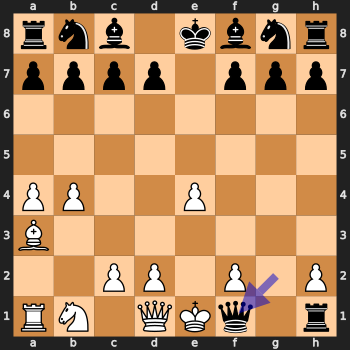

Move: g2f1
-0.30000000000000004
Loss


In [12]:
# Board setup for White's imminent victory
fen = "rnbqkbnr/pppp1ppp/8/8/4P3/8/PPPP1PPP/RNBQKB1r w Qkq - 0 4"

statistics_table = statistics_table_black
board = chess.Board(fen)
engine = chess.engine.SimpleEngine.popen_uci(Stockfish_path)
simulations = 35
time_limit=0.01

while not board.is_game_over():
    if board.turn:  # if it's black's turn
        move, root = monte_carlo_tree_search(board, simulations, statistics_table, 'BLACK', time_limit)
    else:
        result = engine.play(board, chess.engine.Limit(time=time_limit))
        move = result.move

    board.push(move)
    a = chess.svg.board(
        board,
        arrows=[chess.svg.Arrow(move.from_square, move.to_square, color="#0000cccc")],
        size=350,
    )
    display(SVG(a))
    print("Move:", move)

print(get_result_white(board))
print(interpret_result_white(board.result()))
engine.quit()